# Investigating accident rates - snowkuma


Now that you have the number of accidents for some road segments, you can investigate and find accident hotspots.

**Note**: This Notebook assumes that you have updated the database by working through Notebook 15.4 and the associated solutions.

First, some boilerplate imports.

In [1]:
# Import the required libraries and open the connection to Mongo

import collections
import datetime
import matplotlib as mpl

import pandas as pd
import scipy.stats

import folium

import pymongo

In [7]:
# Open a connection to the Mongo server, open the accidents database and name the collections of accidents and labels
client = pymongo.MongoClient('mongodb://localhost:27351/')

db = client.accidents
accidents = db.accidents

labels = db.labels
roads = db.roads

In [8]:
list(labels.find())


[{'_id': ObjectId('52b0c65adbc24119018372a0'),
  'codes': {'-1': 'Data missing or out of range',
   '1': 'Fine no high winds',
   '2': 'Raining no high winds',
   '3': 'Snowing no high winds',
   '4': 'Fine + high winds',
   '5': 'Raining + high winds',
   '6': 'Snowing + high winds',
   '7': 'Fog or mist',
   '8': 'Other',
   '9': 'Unknown'},
  'label': 'Weather_Conditions'},
 {'_id': ObjectId('52b0c65adbc24119018372a1'),
  'codes': {'1': '0 - 5',
   '10': '66 - 75',
   '11': 'Over 75',
   '2': '6 - 10',
   '3': '11 - 15',
   '4': '16 - 20',
   '5': '21 - 25',
   '6': '26 - 35',
   '7': '36 - 45',
   '8': '46 - 55',
   '9': '56 - 65'},
  'label': 'Age_Band_of_Driver'},
 {'_id': ObjectId('52b0c65adbc24119018372a2'),
  'codes': {'-1': 'Data missing or out of range',
   '0': 'None',
   '1': 'Previous accident',
   '10': 'Kerb',
   '11': 'Other object',
   '12': 'Any animal (except ridden horse)',
   '2': 'Road works',
   '4': 'Parked vehicle',
   '5': 'Bridge (roof)',
   '6': 'Bridge (si

In [3]:
# Load the expanded names of keys and human-readable codes into memory
expanded_name = collections.defaultdict(str)
for e in labels.find({'expanded': {"$exists": True}}):
    expanded_name[e['label']] = e['expanded']
    
label_of = collections.defaultdict(str)
for l in labels.find({'codes': {"$exists": True}}):
    for c in l['codes']:
        try:
            label_of[l['label'], int(c)] = l['codes'][c]
        except ValueError: 
            label_of[l['label'], c] = l['codes'][c]

In [4]:
def add_accidents_markers(the_map, query, number_of_sides=5, fill_color='#769d96', limit=0,
                     radius=5, rotation=54):
    for a in accidents.find(query, 
                            ['loc.coordinates'],
                            limit=limit):
        folium.RegularPolygonMarker(location=[a['loc']['coordinates'][1], a['loc']['coordinates'][0]], 
                     number_of_sides=number_of_sides, radius=radius, rotation=rotation,
                                   fill_color=fill_color).add_to(the_map)  

In [5]:
def add_roads_markers(the_map, query, number_of_sides=5, fill_color='#769d96', limit=0,
                     radius=5, rotation=54):
    for r in roads.find(query, 
                        ['loc.coordinates'],
                       limit=limit):
        folium.RegularPolygonMarker(location=[r['loc']['coordinates'][1], r['loc']['coordinates'][0]], 
                     number_of_sides=number_of_sides, radius=radius, rotation=rotation,
                                   fill_color=fill_color).add_to(the_map)   

## Exploring accident counts
Now that most of the road segments are annotated with the accidents that are nearby, we can investigate accident rates.

In [6]:
# Build a DataFrame, one row for each accident
nac_unrolled_df = pd.DataFrame(list(roads.find({}, ['nearby_accident_count'])))

# Count the number of each severity
nac_ss = nac_unrolled_df['nearby_accident_count'].value_counts()
nac_ss

0     3061
1     2853
2     2407
3     2089
4     1631
5     1298
6      935
7      676
8      604
9      507
10     324
11     274
12     246
13     191
14     144
16     116
15     115
18      74
17      64
20      55
19      53
21      38
22      34
24      24
25      20
23      18
26      17
27      16
28      14
29      11
      ... 
31       8
30       7
38       6
33       5
34       5
36       4
43       4
35       4
39       2
42       2
48       2
49       2
96       1
46       1
50       1
77       1
45       1
40       1
60       1
51       1
88       1
52       1
74       1
37       1
53       1
54       1
73       1
47       1
41       1
63       1
Name: nearby_accident_count, Length: 61, dtype: int64

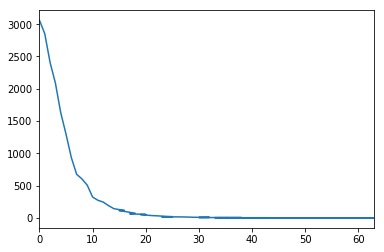

In [7]:
nac_ss.plot()

It's obvious that most road segments have only a few accidents allocated to them, while a few have many.

Let's take a look at where the most accident-prone road segments are.

In [8]:
m = folium.Map([55, -3], zoom_start=6)    
add_roads_markers(m, {'loc': {'$exists': True},
                      'nearby_accident_count': {'$gte': 40}})
m

Nothing particularly illuminating. Most of the accident-prone road sections are in central London, which isn't a great surprise.

In [9]:
milton_keynes = {'type': 'Polygon',
                 'coordinates': [[[-0.877025, 52.092317],
                                  [-0.651709, 52.092317],
                                  [-0.651709, 51.958628],
                                  [-0.877025, 51.958268],
                                  [-0.877025, 52.092317]
                                 ]]}

min_mk_lat = min(p[1] for p in milton_keynes['coordinates'][0])
max_mk_lat = max(p[1] for p in milton_keynes['coordinates'][0])
min_mk_lon = min(p[0] for p in milton_keynes['coordinates'][0])
max_mk_lon = max(p[0] for p in milton_keynes['coordinates'][0])

mk_centre = [min_mk_lat + (max_mk_lat - min_mk_lat) / 2, min_mk_lon + (max_mk_lon - min_mk_lon) / 2]

mk_region_query = {'loc': {'$geoWithin': {'$geometry': milton_keynes}}}

In [10]:
import math 

m = folium.Map(mk_centre, zoom_start=9)    
query = {'loc':
                      {'$nearSphere':
                       {'$geometry': 
                        {'type': 'Point', 'coordinates': list(reversed(mk_centre))},
                        '$maxDistance': 50000}}}

for r in roads.find(query):
    folium.RegularPolygonMarker(location=[r['loc']['coordinates'][1], r['loc']['coordinates'][0]], 
                     number_of_sides=9, fill_color='#ff0000',
                    radius=(math.log10(r['nearby_accident_count']+1)*6)).add_to(m)

m

Nothing immediately obvious leaps out about accident hotspots. There seem to be large numbers of accidents near towns, but that is likely because there are lots of road segments and drivers near towns. 

Raw 'number of accidents' per road section isn't that interesting, as the road sections are different lengths. We could look at the number of accidents per kilometre, or the number of accidents per vehicle-kilometre. 

In [11]:
pipeline = []
pipeline = [{'$project': {'_id': '$CP',
                          'accidents_per_km': {'$divide': ['$nearby_accident_count', '$LenNet']}}}]

a_per_km_df = pd.DataFrame(list(roads.aggregate(pipeline)))
a_per_km_df.set_index('_id', inplace=True)
a_per_km_df.index.name = 'CP'
a_per_km_df

,accidents_per_km
CP,
506,0.119048
508,0.416667
509,0.103093
510,0.465116
512,0.434783
514,0.468750
515,0.147059
516,0.333333
520,0.000000


count    17987.000000
mean         5.131735
std         12.415425
min          0.000000
25%          0.357143
50%          1.600000
75%          5.000000
max        310.000000
Name: accidents_per_km, dtype: float64

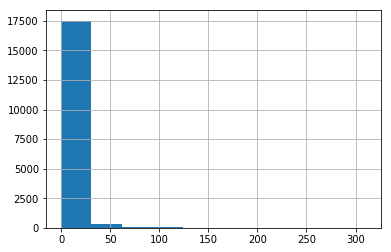

In [12]:
a_per_km_df['accidents_per_km'].hist()
a_per_km_df['accidents_per_km'].describe()

There's a road with 310 accidents per kilometre? Where?

In [13]:
a_per_km_df.loc[a_per_km_df['accidents_per_km'].idxmax()]

accidents_per_km    310.0
Name: 56431, dtype: float64

In [14]:
roads.find_one({'CP': int(a_per_km_df['accidents_per_km'].idxmax())})

{'A-Junction': 'Regent St',
 'AADFYear': 2012,
 'B-Junction': 'Great Portland St',
 'CP': 56431,
 'Fd2WMV': 463.0,
 'FdAll_MV': 10000.0,
 'FdBUS': 2832.0,
 'FdCar': 6193.0,
 'FdHGV': 59.0,
 'FdHGVA3': 0.0,
 'FdHGVA5': 0.0,
 'FdHGVA6': 0.0,
 'FdHGVR2': 46.0,
 'FdHGVR3': 13.0,
 'FdHGVR4': 0.0,
 'FdLGV': 454.0,
 'FdPC': 3691.0,
 'Latitude': 51.515434733123556,
 'LenNet': 0.1,
 'LenNet_miles': 0.06,
 'Longitude': -0.14114462424095864,
 'ONS GOR Name': 'London',
 'ONS LA Name': 'Westminster',
 'RCat': 'PU',
 'Road': 'A40',
 'S Ref E': 529080,
 'S Ref N': 181250,
 '_id': ObjectId('533ed2c589f6f9ee18bb1264'),
 'loc': {'coordinates': [-0.14114462424095864, 51.515434733123556],
  'type': 'Point'},
 'nearby_accident_count': 31,
 'nearby_accidents': ['201201CW10007',
  '201201CW10142',
  '201201CW10275',
  '201201CW10411',
  '201201CW10437',
  '201201CW10577',
  '201201CW10591',
  '201201CW10599',
  '201201CW10639',
  '201201CW10902',
  '201201CW10910',
  '201201CW10925',
  '201201CW10927',
  '20

### Activity 1
Find the number of accidents per kilometre, and the number of accidents per vehicle-kilometre, for each road category.

(Use the `FdAll_MV` data for the number of vehicles using a road section.)

The solution is in the [`15.5solutions`](15.5solutions.ipynb) Notebook.

In [16]:
# Insert your solution here.
# another crazy looking pipeline

pipeline = [{'$group': {'_id': '$RCat',
                      'FdAll_MV': {'$sum': '$FdAll_MV'},
                      'LenNet': {'$sum': '$LenNet'},
                      'nearby_accident_count': {'$sum': '$nearby_accident_count'}}},
          {'$project': {'accidents_per_km': {'$divide': ['$nearby_accident_count', '$LenNet']},
                       'accidents_per_vehicle_km': {'$divide': ['$nearby_accident_count', {'$multiply': ['$LenNet', '$FdAll_MV']}]}}}]

results = list(roads.aggregate(pipeline))
results_df = pd.DataFrame(results)
results_df.set_index('_id', inplace=True)
results_df

,accidents_per_km,accidents_per_vehicle_km
_id,,
PM,3.260870,1.629775e-06
TM,1.513856,1.941054e-08
TR,0.770881,1.698353e-08
PR,0.633014,9.050137e-09
PU,4.295740,2.622580e-08
TU,2.952880,2.841555e-07


### Activity 2
Plot a map of the road sections within 50km of Milton Keynes with accidents, with the size of marker dependent on the accidents per vehicle-km on that road section. If a road section doesn't have a meaningful accident per vehicle-km, it should be discarded from the display.

Note that the accident rate per vehicle-kilometre spans several orders of magnitude, so you should use a marker size based on the logarithm of the rate. 

The solution is in the [`15.5solutions`](15.5solutions.ipynb) Notebook.

In [20]:
import math

# Plot all the road segments within 50km of Milton Keynes

m = folium.Map([52.0395099, -0.7601851], zoom_start=9)

query = {'loc': 
         {'$nearSphere': 
          {'$geometry': \
           {'type': 'Point', 
            'coordinates': [-0.7601851, 52.0395099]},
           '$maxDistance': 50000}},
        'LenNet': {'$exists': True},
        'nearby_accident_count': {'$gt': 0}}

for r in roads.find(query):
    folium.RegularPolygonMarker(location=[r['loc']['coordinates'][1], r['loc']['coordinates'][0]],
                               number_of_sides=9, fill_color='#ff0000',
                               radius=(math.log10(r['nearby_accident_count'] / (r['LenNet'] * r['FdAll_MV'])) + 6) * 3).add_to(m)
m

### Activity 3
What's the most dangerous road segment in Milton Keynes?

The solution is in the [`15.5solutions`](15.5solutions.ipynb) Notebook.

### The question is vague
there a re anumber of possible meanings of 'most dangerous'.  it could be the segment with the most accidents, the most accidents per km, or the most accidents per vehicle-km.

In [22]:
# Most accidents

# $geoNear centered on MK and distance of 10KM
pipeline = [{'$geoNear': {'near': {'type': 'Point', 'coordinates': [-0.7601851, 52.0395099]},
                        'spherical': True,
                        'maxDistance': 10000,
                        'distanceField': 'distance'}},
           {'$project': {'CP': '$CP',
                        'Road': '$Road',
                        'nearby_accident_count': '$nearby_accident_count'}},
           {'$sort': {'nearby_accident_count': -1}},
           {'$limit': 1}]
results = list(roads.aggregate(pipeline))
results

[{'CP': 56004,
  'Road': 'M1',
  '_id': ObjectId('533ed2c589f6f9ee18bb1139'),
  'nearby_accident_count': 26}]

In [23]:
# Most accidents per KM

# $geoNear centered on MK and distance of 10KM
pipeline = [{'$geoNear': {'near': {'type': 'Point', 'coordinates': [-0.7601851, 52.0395099]},
                        'spherical': True,
                        'maxDistance': 10000,
                        'distanceField': 'distance'}},
           {'$project': {'CP': '$CP',
                        'Road': '$Road',
                        'accidents_per_km': {'$divide': ['$nearby_accident_count', '$LenNet']}}},
           {'$sort': {'accidents_per_km': -1}},
           {'$limit': 1}]
results = list(roads.aggregate(pipeline))
results

[{'CP': 99273,
  'Road': 'A421',
  '_id': ObjectId('533ed2c689f6f9ee18bb2e40'),
  'accidents_per_km': 28.0}]

In [25]:
# Most accidents per vehicle KM

# $geoNear centered on MK and distance of 10KM
pipeline = [{'$geoNear': {'near': {'type': 'Point', 'coordinates': [-0.7601851, 52.0395099]},
                        'spherical': True,
                        'maxDistance': 10000,
                        'distanceField': 'distance'}},
           {'$project': {'CP': '$CP',
                        'Road': '$Road',
                        'accidents_per_vehicle_km': {'$divide': ['$nearby_accident_count', 
                                                                 {'$multiply': ['$LenNet', '$FdAll_MV']}]}}},
           {'$sort': {'accidents_per_vehicle_km': -1}},
           {'$limit': 1}]
results = list(roads.aggregate(pipeline))
results

[{'CP': 99246,
  'Road': 'A421',
  '_id': ObjectId('533ed2c689f6f9ee18bb2e2d'),
  'accidents_per_vehicle_km': 0.0013240539220959774}]

### Activity 4
What are the proportions of casualty class (e.g. `accident.Casualty_Class`) for accidents that occur on different road classes? Are there significant differences between the proportions of casualty classes?

The solution is in the [`15.5solutions`](15.5solutions.ipynb) Notebook.

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 8)

In [29]:
# verbose for loop method
casualty_class_by_road_cat_list = []

for r in roads.find({'nearby_accidents': {'$exists': True}}):
    for ai in r['nearby_accidents']:
        a = accidents.find_one({'Accident_Index': ai})
        for c in a['Casualties']:
            casualty_class_by_road_cat_list += [{'RCat': r['RCat'],
                                                'Casualty_Class': label_of[('Casualty_Class', c['Casualty_Class'])]}]

casualty_class_by_road_cat_unrolled_df = pd.DataFrame(casualty_class_by_road_cat_list)
casualty_class_by_road_cat_unrolled_df

,Casualty_Class,RCat
0,Driver or rider,TR
1,Driver or rider,TR
2,Pedestrian,TR
3,Driver or rider,TR
4,Driver or rider,TR
5,Driver or rider,TR
6,Driver or rider,TR
7,Driver or rider,TR
8,Driver or rider,TR
9,Driver or rider,TR


In [32]:
# List comprehensions
casualty_class_by_road_cat_unrolled_df2 = pd.DataFrame([
    {'RCat': r['RCat'], 'Casualty_Class': label_of[('Casualty_Class', c['Casualty_Class'])]}
    for r in roads.find({'nearby_accidents': {'$exists': True}})
    for ai in r['nearby_accidents']
    for a in accidents.find({'Accident_Index': ai})
    for c in a ['Casualties']
])
casualty_class_by_road_cat_unrolled_df2

,Casualty_Class,RCat
0,Driver or rider,TR
1,Driver or rider,TR
2,Pedestrian,TR
3,Driver or rider,TR
4,Driver or rider,TR
5,Driver or rider,TR
6,Driver or rider,TR
7,Driver or rider,TR
8,Driver or rider,TR
9,Driver or rider,TR


In [34]:
# now we can count the number of each severity
casualty_class_by_road_cat_df = pd.crosstab(casualty_class_by_road_cat_unrolled_df['RCat'],
                                           casualty_class_by_road_cat_unrolled_df['Casualty_Class'])
casualty_class_by_road_cat_df

Casualty_Class,Driver or rider,Passenger,Pedestrian
RCat,,,
PM,149,75,2
PR,18234,6764,881
PU,37473,13540,8508
TM,5820,2983,51
TR,6576,2925,133
TU,1164,537,71


In [35]:
# we need to drop the PM row as there are too few pedestrians there
casualty_class_by_road_cat_df.drop('PM', inplace=True)
casualty_class_by_road_cat_df

Casualty_Class,Driver or rider,Passenger,Pedestrian
RCat,,,
PR,18234,6764,881
PU,37473,13540,8508
TM,5820,2983,51
TR,6576,2925,133
TU,1164,537,71


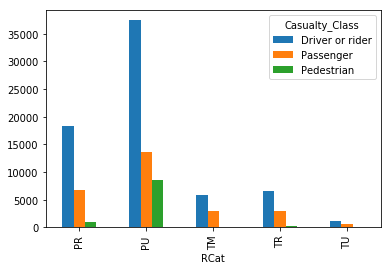

In [36]:
casualty_class_by_road_cat_df.plot(kind='bar')

if we want to find statistical significance we need to do a test.  As it is categorised a chi-squared test is appropriate.

First we calculate the exp number of casualties for each class and each road type, trhen perform the test by comparing the two DF

In [1]:
chi2, p, _, _ =scipy.stats.chi2_contingency(casualty_class_by_road_cat_df)
chi2, p

NameError: name 'scipy' is not defined

In [ ]:
# helper function to fill out boilerplate code
def kmeans_plot(df, x_column, y_column, k,
                cluster_labels=None, plt_labels=None, plt_title=None,
                colors=None
               ):
    
    # determine the ranges of the data
    x_range = [min(df[x_column]), max(df[y_column])]
    
    # generate sets of random centroids
    init_centroids = random_centroids(x_range, y_range, k)
    
    # create k-means cluster object
    kmeans_clust = cluster.KMeans(n_clusters=k, init=init_centroids)
    
    # fit the objest to the data
    assigned_clust = kmeans_clust.fit(df[[x_column, y_column]])
    
    # plot the kmeans cluster
    plot_cluster(df[x_column], df[y_column], assigned_clust, k,
                 cluster_labels=cluster_labels, plt_labels=plt_labels,
                 plt_title=plt_title, colors=colors
                )

Yes, we can see that different types of road have different mixes of casualties

## Summary
The combination of traffic volume data and accident data allows us to get a richer and more nuanced view of road safety. Rather than just looking for areas with many accidents, we can look at where the accident rate is highest compared to the traffic volumes. 

This is a typical part of data investigations and is one you'll come back to in this module, particularly in the EMA.

## What next?
If you are working through this Notebook as part of an inline exercise, return to the module materials now.

If you are working through this set of Notebooks as a whole, you've completed the Part 15 Notebooks. It's time to move on to Part 16.